# An implementation of the Ant miner paper for Emotion Recognition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, 
NavigationToolbar2Tk)
import copy
from tkinter import *
from tkinter import ttk
from pandastable import Table

In [2]:
df = pd.read_csv("Resources/Ravdess Dataset.csv")
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f643,f644,f645,f646,f647,f648,f649,f650,f651,class
0,-675.852,-820.630,-372.474,156.448,0.455,-1.471,68.959,-15.910,217.757,72.966,...,15.036,-3.957,32.880,0.023,-110.137,112.829,20.504,-0.442,17.036,neutral
1,-640.294,-783.178,-358.277,154.661,0.411,-1.555,64.627,-47.438,218.073,76.974,...,12.265,-4.655,30.513,-0.725,-82.309,67.398,13.982,-1.941,19.824,neutral
2,-677.497,-825.274,-375.799,157.171,0.415,-1.537,66.738,-79.028,208.915,73.381,...,22.398,-2.424,37.887,-0.037,-169.023,170.742,30.984,0.124,18.527,neutral
3,-659.499,-809.578,-356.445,164.199,0.455,-1.502,61.317,-70.403,214.674,75.767,...,10.528,1.095,18.721,-0.004,-59.714,50.999,13.634,-0.887,10.296,neutral
4,-698.072,-857.808,-409.923,156.816,0.281,-1.594,70.695,-55.799,221.357,70.646,...,24.944,-2.291,42.875,0.022,-253.151,210.330,35.594,-0.635,28.814,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-528.333,-659.763,-241.697,164.582,0.572,-1.545,49.885,-36.404,205.386,69.445,...,14.937,1.440,10.757,-0.162,-69.727,107.401,18.274,1.613,15.420,surprised
1436,-609.369,-757.083,-307.215,179.786,0.575,-1.516,63.774,-32.482,223.057,77.018,...,10.696,0.127,1.252,-0.151,-39.864,30.325,10.742,-0.514,3.439,surprised
1437,-550.021,-686.908,-257.205,164.957,0.545,-1.525,57.948,-62.416,214.069,71.946,...,11.213,-0.678,3.609,-0.190,-46.936,48.720,11.619,0.666,5.487,surprised
1438,-559.621,-688.898,-280.156,160.536,0.578,-1.527,57.994,-17.436,206.204,75.294,...,14.703,-1.261,15.954,-0.240,-87.877,85.553,17.354,0.738,15.653,surprised


In [78]:
class Window:
    def __init__(self,title,geometry):
        self.w = Tk()
        self.w.title(title)
        self.w.option_add('*Font','25')
        self.w.geometry(geometry)
        self.frame = ttk.Frame(self.w, padding="12 12 12 12")
        self.progress = ttk.Frame(self.w, padding="12 12 12 12")
        self.dataframe = ttk.Frame(self.w,padding="12 12 12 12")
        self.tf  = ttk.Frame(self.w, padding="12 12 12 12")
        self.frame.place(relx=0.1,rely=0.2)
        self.tf.place(relx=0.3725,rely=0.26146789)
        self.dataframe.place(relx=0.8,rely=0.4)
        self.progress.place(relx=0.75, rely=0.6)
    
    def label(self,text):
        ttk.Label(self.frame,text=str(text),wraplength=600).pack()
    
    def exit_button(self,text="Next"):
        self.exit = ttk.Button(self.frame,text=text,command=self.w.destroy)
        self.exit.pack()
        

In [66]:
win = Window(title="Welcome!",geometry="800x100")

win.label("Welcome! This is an example of how the output will be displayed in this code.")
win.exit_button()
win.w.mainloop()

In [5]:
n_candidate_thresholds = 10

In [6]:
candidate_thresholds = df.quantile(np.linspace(0, 1, n_candidate_thresholds))

win = Window(title="candidate_thresholds",geometry='1000x500')
win.label("Following is the candidate threshold array:")

ct_table = Table(win.tf,dataframe=candidate_thresholds,showtoolbar=True,showstatusbar=True)
ct_table.show()
win.exit_button()
win.w.mainloop()

In [7]:
emotions = df['class'].unique()
#emotions

win = Window(title="List of Emotions",geometry="800x100")
win.label("These are the possible emotions in our dataset:")
win.label(emotions)

win.exit_button()
win.w.mainloop()

In [8]:
cols = df.columns

In [9]:
GE_df = pd.DataFrame(columns=cols)
GE_df = GE_df.drop('class', axis=1)
LT_df = GE_df.copy(deep=True)
GE_df


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f642,f643,f644,f645,f646,f647,f648,f649,f650,f651


In [10]:
GE = np.zeros((n_candidate_thresholds, len(cols) - 1, len(emotions)))
LT = GE.copy()
GE.shape

win = Window(title="GE and LT",geometry="800x150")
win.label("GE and LT are two same-size arrays we will use to measure entropy in our dataset. GE represents greater than and LT represents Lesser Than.")
win.label(GE.shape)

win.exit_button()
win.w.mainloop()

In [11]:
for e, emotion in enumerate(emotions):
    for i, (quantile, row) in enumerate(candidate_thresholds.iterrows()):
        GE_df.loc[i] = df.loc[df['class'] == emotion].drop('class', axis=1).ge(candidate_thresholds.iloc[i]).sum()
        LT_df.loc[i] = df.loc[df['class'] == emotion].drop('class', axis=1).lt(candidate_thresholds.iloc[i]).sum()
    GE[:, :, e] = GE_df.to_numpy()
    LT[:, :, e] = LT_df.to_numpy()

win = Window(title="GE and LT assignment",geometry="800x100")
win.label("This is a compute intensive step where GE_df and LT_df are assigned values to use later.")

win.exit_button()
win.w.mainloop()

In [12]:
train, test = np.split(df.sample(frac=1), [int(0.75*len(df))])
train_len = len(train)
test_len = len(test)
total_len = train_len + test_len
test_len, train_len, total_len

win = Window(title="Initial training variables",geometry="800x100")
win.label("Here we set our test_len, train_len and total_len.")
win.label([test_len, train_len, total_len])

win.exit_button()
win.w.mainloop()

# Entropy values
H will be a matrix of size (1 x features). Computed in a vectorized way to save time (This would take like 10 mins if it was in a for loop, now it takes 10s). <br>
Ok fine I'm looping through the 8 emotions so techhhhnically it's not fully vectorized. Anyway we're computing H only once so I took lite

In [13]:
sums_GE = np.sum(GE, axis=2)
sums_LT = np.sum(LT, axis=2)
#sums_GE

In [14]:
repeated_sums_GE = np.repeat(sums_GE[:, :, np.newaxis], GE.shape[2], axis=2)
repeated_sums_LT = np.repeat(sums_LT[:, :, np.newaxis], LT.shape[2], axis=2)
#repeated_sums_GE[:, :, 1]

In [15]:
P_GE = np.divide(GE, repeated_sums_GE, out=np.zeros_like(GE), where=repeated_sums_GE!=0)
P_LT = np.divide(LT, repeated_sums_LT, out=np.zeros_like(LT), where=repeated_sums_LT!=0)
#P_GE

In [16]:
logP_GE = np.log2(P_GE, out=np.zeros_like(P_GE), where=P_GE>0)
logP_LT = np.log2(P_LT, out=np.zeros_like(P_LT), where=P_LT>0)
#logP_GE

In [17]:
GE = -np.sum(np.multiply(P_GE, logP_GE), axis=2)
LT = -np.sum(np.multiply(P_LT, logP_LT), axis=2)

win = Window(title="Entropy Calcuation",geometry="800x150")
win.label("""Now we use GE and LT to calculate entropies for each entry in the dataset.
Essentially, GE and LT are recalculated first as P_GE = GE / ( sum(GE) along the 3rd axis). 
Then the final value is calculated as -1 * sum( P_GE * log2(P_GE) ) along the 3rd axis.""")

win.exit_button()
win.w.mainloop()

In [18]:
epv = sums_LT * LT / (sums_GE + sums_LT) + sums_GE * GE / (sums_GE + sums_LT)
epv.shape

win = Window(title="EPV",geometry="800x150")
win.label("Now we calculate epv, which is defined as new LT * sum(LT) + new GE * sum(GE) over sum(GE) + sum(LT). It's shape is given here.")
win.label(epv.shape)

win.exit_button()
win.w.mainloop()

In [19]:
entropies = np.minimum(
                GE[np.argmin(epv, axis=0), np.array(range(len(cols) - 1))],
                LT[np.argmin(epv, axis=0), np.array(range(len(cols) - 1))]
            )
#entropies

win = Window(title="Entropy calculation",geometry="800x100")
win.label("Finally, the entropies array is entered as the element-wise minimum of GE[argmin(epv)] and LT[argmin(epv)].")

win.exit_button()
win.w.mainloop()

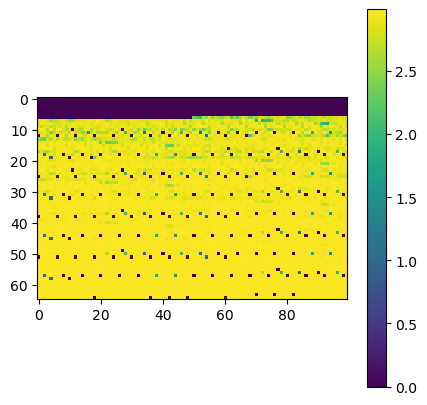

In [20]:
vis = LT[:, :-2]
vis = vis.reshape(65,100)
#plt.imshow(vis)
#plt.colorbar()
#plt.show()

win = Window(title="Colorplot showing entropy values",geometry="800x600")
win.label("Following is the colorplot of the array vis, made from LT:")

figure = plt.figure(figsize=(5,5),dpi=100)
plot = figure.add_subplot(111)
bar = plot.imshow(vis)
figure.colorbar(bar)

canvas = FigureCanvasTkAgg(figure,win.tf)
canvas.get_tk_widget().grid()

win.exit_button()
win.w.mainloop()


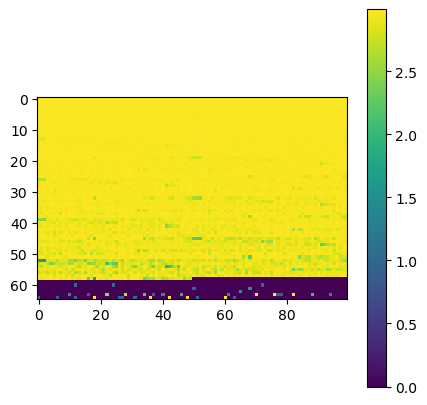

In [21]:
vis = GE[:, :-2]
vis = vis.reshape(65,100)
#plt.imshow(vis)
#plt.colorbar()
#plt.show()

win = Window(title="Colorplot showing entropy values",geometry="800x600")
win.label("Following is the colorplot of the array vis, made from GE:")

figure = plt.figure(figsize=(5,5),dpi=100)
plot = figure.add_subplot(111)
bar = plot.imshow(vis)
figure.colorbar(bar)

canvas = FigureCanvasTkAgg(figure,win.tf)
canvas.get_tk_widget().grid()

win.exit_button()
win.w.mainloop()

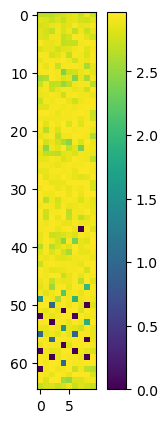

In [22]:
vis = entropies[:-2]
vis = vis.reshape(65,10)
#plt.imshow(vis)
#plt.colorbar()
#plt.show()

win = Window(title="Colorplot showing entropy values",geometry="800x600")
win.label("Following is the colorplot of the array vis, made from the entropies array:")

figure = plt.figure(figsize=(3,5),dpi=100)
plot = figure.add_subplot(111)
bar = plot.imshow(vis)
figure.colorbar(bar)

canvas = FigureCanvasTkAgg(figure,win.tf)
canvas.get_tk_widget().grid()

win.exit_button()
win.w.mainloop()

In [23]:
%load_ext line_profiler
def calc_threshold_and_operator(dataset):
    GE_df = pd.DataFrame(columns=[dataset.columns[0]])
    LT_df = GE_df.copy(deep=True)
    GE = np.zeros((n_candidate_thresholds, 1, len(emotions)))
    LT = GE.copy()
    cands = candidate_thresholds[dataset.columns[0]]
    
    for e, emotion in enumerate(emotions):
        for i, (quantile, row) in enumerate(candidate_thresholds.iterrows()):
            GE_df.loc[i] = dataset.loc[dataset['class'] == emotion].drop('class', axis=1).ge(cands.iloc[i]).sum()
            LT_df.loc[i] = dataset.loc[dataset['class'] == emotion].drop('class', axis=1).lt(cands.iloc[i]).sum()
        GE[:, :, e] = GE_df.to_numpy()
        LT[:, :, e] = LT_df.to_numpy()
        
    sums_GE = np.sum(GE, axis=2)
    sums_LT = np.sum(LT, axis=2)
    
    repeated_sums_GE = np.repeat(sums_GE[:, :, np.newaxis], GE.shape[2], axis=2)
    repeated_sums_LT = np.repeat(sums_LT[:, :, np.newaxis], LT.shape[2], axis=2)
    
    P_GE = np.divide(GE, repeated_sums_GE, out=np.zeros_like(GE), where=repeated_sums_GE!=0)
    P_LT = np.divide(LT, repeated_sums_LT, out=np.zeros_like(LT), where=repeated_sums_LT!=0)
    
    logP_GE = np.log2(P_GE, out=np.zeros_like(P_GE), where=P_GE>0)
    logP_LT = np.log2(P_LT, out=np.zeros_like(P_LT), where=P_LT>0)
    
    GE = -np.sum(np.multiply(P_GE, logP_GE), axis=2)
    LT = -np.sum(np.multiply(P_LT, logP_LT), axis=2)
    
    epv = sums_LT * LT / (sums_GE + sums_LT) + sums_GE * GE / (sums_GE + sums_LT)
    vbest = np.argmin(epv, axis=0)
    
    if GE[vbest, 0] < LT[vbest, 0]:
        return float(cands.iloc[vbest]), '>='
    
    return float(cands.iloc[vbest]), '<'

In [24]:
features = df.drop('class', axis=1).columns
logK = np.log2(len(emotions))

In [58]:
class Rule:
    def __init__(self, train_set):
        self.terms = {}
        #{1:1, 18:1}
        #{1:('>=', 13), 2:('<', 0.2)}
        self.emotion = None
        self.numerosity = 0
        self.train_set = train_set
        self.match_set = train_set
    
    def match(self, instance):
        for key, value in instance.items():
            if key in self.terms:
                if self.terms[key][0] == '<' and self.terms[key][1] <= value:
                    return False
                elif self.terms[key][0] == '>=' and self.terms[key][1] > value:
                    return False
        return True
    
    def new_match_set(self, term):
        if term['value'][0] == '>=':
            return self.match_set.loc[self.match_set['f' + str(term['feature'])] >= term['value'][1]]
        return self.match_set.loc[self.match_set['f' + str(term['feature'])] < term['value'][1]]
    
    def unmatch_set(self):
        return pd.concat([self.train_set, self.match_set, self.match_set]).drop_duplicates(keep=False)
    
    def correct_set(self):
        return self.match_set.loc[self.match_set['class'] == self.emotion]
    
    def exists(self, feature):
        return feature in self.terms
        
    def addTerm(self, term, new_matches):
        self.terms[term['feature']] = term['value']
        self.match_set = new_matches
        self.numerosity += 1
        
    def computeTerm(self, attribute):
        pass
        
    def quality(self):
        matches = self.match_set
        unmatches = self.unmatch_set()
        TP = len(matches.loc[matches['class'] == self.emotion])
        FP = len(matches.loc[matches['class'] != self.emotion])
        FN = len(unmatches.loc[unmatches['class'] == self.emotion])
        TN = len(unmatches.loc[unmatches['class'] != self.emotion])
        
        sens = TP / (TP + FN)
        spec = TN / (FP + TN)
        
        return sens * spec
        
    def prune(self):
        print("In pruning")
        #Storing previous best rule
        BackupTerms = self.terms.copy()
    
        # Keys of the terms. (features)
        rule_keys = list(BackupTerms.copy().keys())
        maxQuality = self.quality()
        
        #Rule must be atleast one term.
        for i in range(self.numerosity,0,-1):
            
            #Getting all possible subsets , of length i, of the terms.
            for subset in itertools.combinations(rule_keys,i):
                #Converting it to a dictionary.
                self.terms = {l: self.terms[l] for l in list(subset)}
      
              
                #Comparing the qualities and storing the maximal of the two.
                if maxQuality >= self.quality():
                    self.terms = BackupTerms.copy()
                
                else:
                    BackupTerms = self.terms.copy()
        

In [59]:
def normalize_probs(probs):
    return probs / np.sum(probs)

In [60]:
class Ant:
    def __init__(self, index, train_set, n_tries, min_coverage):
        self.index = index
        self.rule = Rule(train_set)
        self.n_tries = n_tries
        self.min_coverage = min_coverage
    
    def traverse(self, T):
        Eta = logK - entropies

        Probs = np.multiply(Eta, T)
        Probs = normalize_probs(Probs)
        
        should_continue = True
        while(should_continue):
            tries = self.n_tries
            while(tries):
                chosen = int(np.random.choice(len(Probs), 1, p=Probs))
                v, op = calc_threshold_and_operator(self.rule.match_set[['f' + str(chosen), 'class']])
                term = {'feature': chosen, 'value': (op, v)}
                new_cov = self.rule.new_match_set(term)
                if len(new_cov) >= self.min_coverage:
                    self.rule.addTerm(term, new_cov)
                    print("Added " + str(term))
                    
                    Probs[term['feature']] = 0
                    Probs = normalize_probs(Probs)
                    
                    should_continue = True
                    break
                tries -= 1
                should_continue = False
                
    def set_emotion(self):
        matches = self.rule.match_set
        self.rule.emotion = matches['class'].mode()[0]
        

In [82]:
class World:
    def __init__(
        self,
        min_coverage = 10,
        max_uncovered = 10,
        n_ants = 500,
        max_dups = 1,
        tries = 10,
        pruning = False,
        train_set = train.copy(deep=True),
    ):
    
        self.min_coverage = min_coverage
        self.max_uncovered = max_uncovered
        self.n_ants = n_ants
        self.max_dups = max_dups
        self.tries = tries
        self.pruning = pruning
        self.train_set = train_set
        self.pheromone_map = np.ones_like(entropies) * (1 / len(features))
        self.discovered_rule_list = []
        self.correct_covered = 0
        
    def reset_pheromones(self):
        self.pheromone_map = np.ones_like(entropies) * (1 / len(features))

    def deposit_pheromones(self, new_pheromones):
        self.pheromone_map = self.pheromone_map + new_pheromones
        
    def evaporate_pheromones(self):
        self.pheromone_map = self.pheromone_map / np.sum(self.pheromone_map)
        
    def plot_pheromones(self, a):
        vis = self.pheromone_map[:-1]
        vis = vis.reshape(31,21)
        plt.imshow(vis)
        plt.colorbar()
        plt.savefig('Plots/Generation' + str(len(self.discovered_rule_list)) + 'ant' + str(a))
        plt.clf()
        
        for widget in win.tf.winfo_children():
            widget.destroy()
        for widget in win.dataframe.winfo_children():
            widget.destroy()

        figure = plt.figure(figsize=(5,5),dpi=100)
        plot = figure.add_subplot(111)
        bar = plot.imshow(vis)
        figure.colorbar(bar)

        canvas = FigureCanvasTkAgg(figure,win.tf)
        canvas.get_tk_widget().grid()
        
        ttk.Label(win.dataframe,text=str("Current generation: "+str(len(self.discovered_rule_list)+1))).pack()
        ttk.Label(win.dataframe,text=str("Current ant number: "+str(a+1))).pack()

        win.w.update()
    
    def dispatch_ants(self):
        prev_rules = []
        prev_qualities = []
        dups = 0
        for a in range(self.n_ants):
            ant = Ant(a, self.train_set, self.tries, self.min_coverage)
            print("initialized ant " + str(a))
            ant.traverse(self.pheromone_map)
            ant.set_emotion()
            if self.pruning:
                ant.rule.prune()
            
            for prev_rule in prev_rules:
                if ant.rule == prev_rule:
                    dups += 1
                    break
            else:
                Q = ant.rule.quality()

                mask = np.zeros_like(entropies)
                mask[list(ant.rule.terms)] = 1
                
                self.deposit_pheromones(np.multiply(self.pheromone_map, mask) * Q)
                self.evaporate_pheromones()

                #if a%20 == 0:
                self.plot_pheromones(a)

                prev_rules.append(ant.rule)
                prev_qualities.append(Q)
                
            if dups > self.max_dups:
                break

        imax = np.argmax(prev_qualities)
        
        return prev_rules[imax]
    
    def discover_rules(self):
        while(len(self.train_set) > self.max_uncovered):
            self.reset_pheromones()
            
            for widget in win.progress.winfo_children():
                widget.destroy()
            ttk.Label(win.progress, text=str("No. of training instances: " + str(len(train)))).pack()
            ttk.Label(win.progress, text=str("No. of correctly covered instances: " + str(self.correct_covered))).pack()
            win.w.update()
                
            best_rule = self.dispatch_ants()
            self.discovered_rule_list.append(best_rule)

            corrects = best_rule.correct_set()
            self.correct_covered += len(corrects)
            
            self.train_set = pd.concat([self.train_set, corrects, corrects]).drop_duplicates(keep=False)
        

In [83]:
def Worldgen(*args):
    a = min_coverage.get()
    b = max_uncovered.get()
    c = n_ants.get()
    d = max_dups.get()
    e = chance_murder_ant.get()
    f = pruning.get()
    world = World(min_coverage=a,max_uncovered=b,n_ants=c,max_dups=d,tries=e, pruning=f)
    world.discover_rules()
    run.destroy()
    win.exit_button()

initialized ant 0
Added {'feature': 237, 'value': ('>=', 3.9219999999999997)}
Added {'feature': 3, 'value': ('>=', 152.02966666666669)}
Added {'feature': 304, 'value': ('<', -0.2443333333333334)}
Added {'feature': 124, 'value': ('>=', 10.725)}
Added {'feature': 629, 'value': ('>=', -222.48055555555555)}
initialized ant 0
Added {'feature': 415, 'value': ('>=', 0.16600000000000004)}
Added {'feature': 565, 'value': ('>=', 0.075)}
initialized ant 0
Added {'feature': 196, 'value': ('<', 0.11844444444444446)}
Added {'feature': 2, 'value': ('>=', -352.4521111111111)}
Added {'feature': 87, 'value': ('>=', 10.081333333333331)}
Added {'feature': 405, 'value': ('<', 0.002)}
initialized ant 0
Added {'feature': 624, 'value': ('>=', 14.934333333333335)}
Added {'feature': 384, 'value': ('<', 2.068)}
Added {'feature': 394, 'value': ('<', 0.09)}
Added {'feature': 241, 'value': ('>=', -818.6033333333332)}
Added {'feature': 237, 'value': ('>=', 3.339)}
initialized ant 0
Added {'feature': 32, 'value': ('<

C:\ProgramData\Anaconda3\envs\ga-aco\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


initialized ant 0
Added {'feature': 120, 'value': ('<', 2.1790000000000003)}
Added {'feature': 437, 'value': ('<', -0.272)}
Added {'feature': 345, 'value': ('<', 4.290111111111111)}
Added {'feature': 625, 'value': ('>=', 2.948888888888889)}
Added {'feature': 307, 'value': ('<', -20.017000000000003)}
Added {'feature': 17, 'value': ('<', 1.4383333333333335)}
initialized ant 0
Added {'feature': 543, 'value': ('<', 6.7940000000000005)}
Added {'feature': 499, 'value': ('>=', 0.052000000000000005)}
Added {'feature': 44, 'value': ('>=', 37.535)}
Added {'feature': 521, 'value': ('<', -0.16899999999999998)}
Added {'feature': 162, 'value': ('>=', -0.004)}
initialized ant 0
Added {'feature': 421, 'value': ('>=', 0.129)}
Added {'feature': 498, 'value': ('<', 0.16499999999999998)}
Added {'feature': 136, 'value': ('<', -2.1350000000000007)}
initialized ant 0
Added {'feature': 269, 'value': ('>=', 5.908666666666667)}
Added {'feature': 347, 'value': ('>=', 1.474)}
Added {'feature': 5, 'value': ('<', -

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\ga-aco\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\Pranav\AppData\Local\Temp/ipykernel_29716/1150796624.py", line 9, in Worldgen
    world.discover_rules()
  File "C:\Users\Pranav\AppData\Local\Temp/ipykernel_29716/134413903.py", line 101, in discover_rules
    for widget in win.progress.winfo_children():
  File "C:\ProgramData\Anaconda3\envs\ga-aco\lib\tkinter\__init__.py", line 959, in winfo_children
    self.tk.call('winfo', 'children', self._w)):
_tkinter.TclError: can't invoke "winfo" command: application has been destroyed


<Figure size 432x288 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

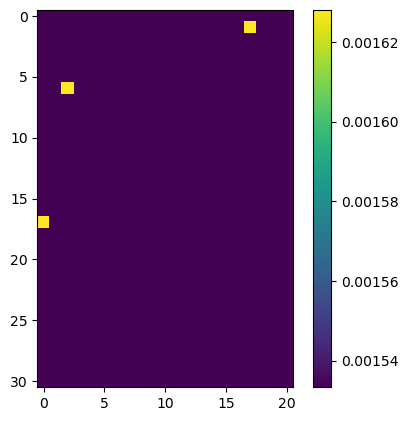

In [84]:
win = Window(title="Algorithm run",geometry="800x1000")
win.label("Now we run the actual program. Enter the required hyperparameters below:")

min_coverage = IntVar(value=10)
win.label("\nmin_coverage:")
ttk.Entry(win.frame,width=7,textvariable=min_coverage).pack()
max_uncovered = IntVar(value=10)
win.label("\nmax_uncovered:")
ttk.Entry(win.frame,width=7,textvariable=max_uncovered).pack()
n_ants = IntVar(value=500)
win.label("\nn_ants:")
ttk.Entry(win.frame,width=7,textvariable=n_ants).pack()
max_dups = IntVar(value=1)
win.label("\nmax_dups:")
ttk.Entry(win.frame,width=7,textvariable=max_dups).pack()
chance_murder_ant = IntVar(value=10)
win.label("\nNumber of tries for each ant:")
ttk.Entry(win.frame,width=7,textvariable=chance_murder_ant).pack()
pruning = BooleanVar(value=False)
win.label("\nPruning?")
ttk.Entry(win.frame,width=7,textvariable=pruning).pack()

run = ttk.Button(text="Run",command=Worldgen)
run.pack()


win.w.mainloop()

In [31]:
from collections import defaultdict

In [ ]:
def predict(row):
    matching_rules = []
    instance = dict(row)
    
    preddict = defaultdict(lambda: 0)
    for rule in world.discovered_rule_list:
        if rule.match(instance):
            preddict[rule.emotion] += 1
            
    if preddict:
        return max(preddict, key=preddict.get)
    return 'unable to predict'

In [ ]:
disc2 = test.copy(deep=True)
disc2.columns = range(len(df.columns))
disc2.rename(columns={652: 'class'}, inplace=True)
disc2['preds'] = 'nothing'

In [ ]:
for i, row in enumerate(disc2.iterrows()):
    disc2.at[i, 'preds'] = predict(disc2.drop(['preds', 'class'], axis=1).iloc[i])
#disc2

In [ ]:
correct = disc2.loc[disc2['class'] == disc2['preds']]
predicted = disc2.loc[disc2['preds'] != 'unable to predict']
len(correct), len(predicted), len(correct)/len(predicted), len(correct)/len(disc2)

# From here it's just random testing

In [ ]:
np.unique(np.random.choice(4, 1000, p=[0, 0.33, 0.33, 0.34]), return_counts=True)

In [ ]:
x = len(features) - 0
Eta = logK - H
denom = x * np.sum(Eta, axis=0)
Eta = np.divide(Eta, denom)

T = np.random.rand(H.shape[0], H.shape[1])
Probs = np.multiply(Eta, T)
denom = x * np.sum(Probs, axis=0)
Probs = np.divide(Probs, denom)
np.sum(Probs)

In [ ]:
flattened = Probs.flatten()
num = np.random.choice(len(flattened), 1, p=flattened)
col = num % 652
row = num // 652
int(col), int(row)